In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [3]:
def load_data_by_dimension(dimension):
    root="./datasets/"
    data_filename = root+f'kryptonite-{dimension}-X.npy'
    labels_filename = root+f'kryptonite-{dimension}-y.npy'

    try:
        data = np.load(data_filename)
        labels = np.load(labels_filename)
        print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
        return data, labels
    except FileNotFoundError:
        print(f"Dataset for dimension {dimension} not found.")
        return None, None

In [4]:
def preprocess_data(data, variance_threshold=0.253):
      variances = np.var(data, axis=0)
      return data[:, variances > variance_threshold]

In [5]:
def plot_optimal_k(dim):
  data, labels = load_data_by_dimension(dim)
  data =  preprocess_data(data, variance_threshold=0.253)

  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
  krange = list(range(1,30,2))+[35,45,55,65,75,85,95,101]
  accuracies=[]
  for k in krange:
    model = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(model, X_train, y_train, cv=5)
    accuracies.append(np.mean(acc))
  plt.rcdefaults()
  plt.figure(figsize=(10, 5))
  plt.plot(krange, accuracies, marker='o', linestyle='-', color='b')
  plt.xlabel('Value of K')
  plt.ylabel('Accuracy')
  plt.title(f'kNN Performance for different K (dim={dim})')
  plt.grid(True)
  plt.show()

## kryptonite-9

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


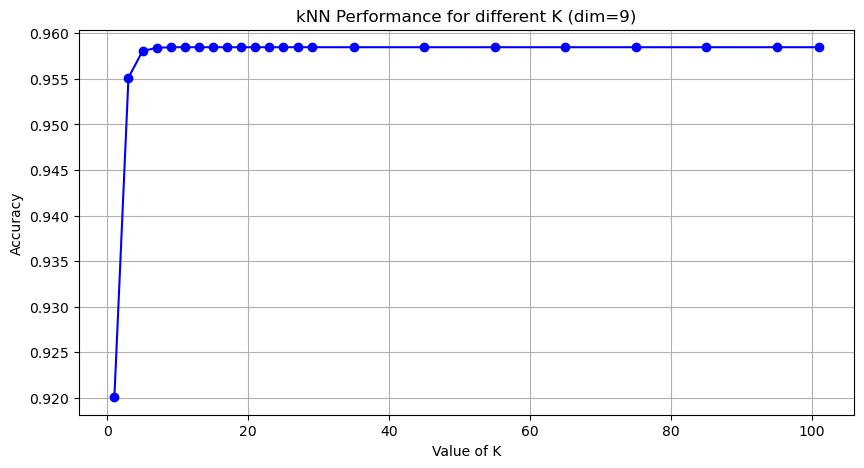

In [6]:
plot_optimal_k(9)

## kryptonite-12

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


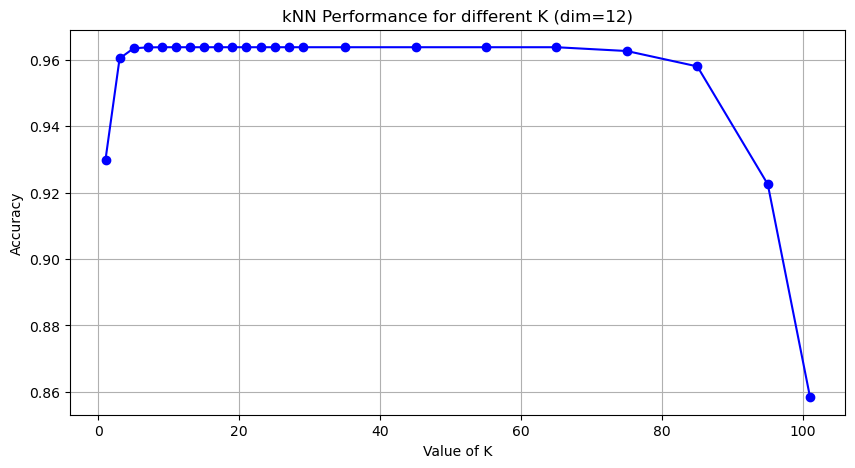

In [7]:
plot_optimal_k(12)

## kryptonite-15

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


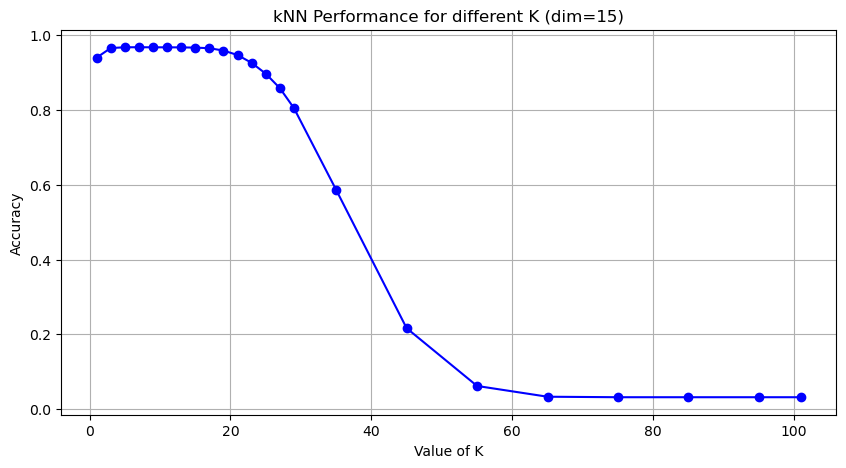

In [8]:
plot_optimal_k(15)

## kryptonite-18

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


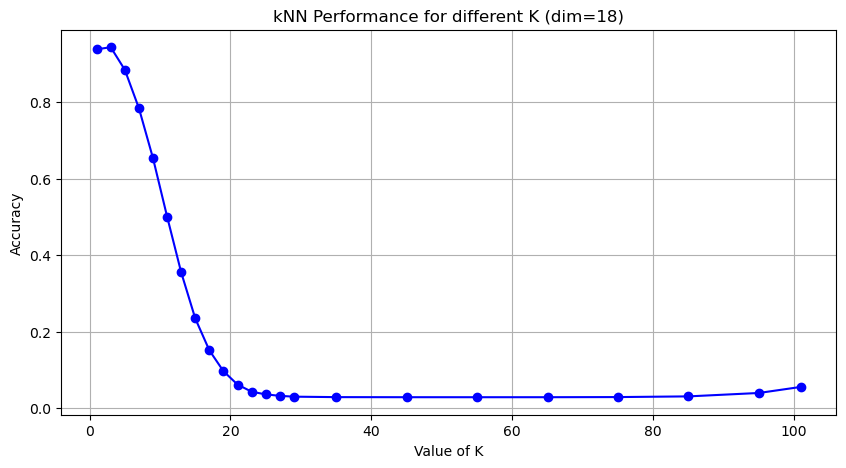

In [9]:
plot_optimal_k(18)

## kryptonite-24


Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


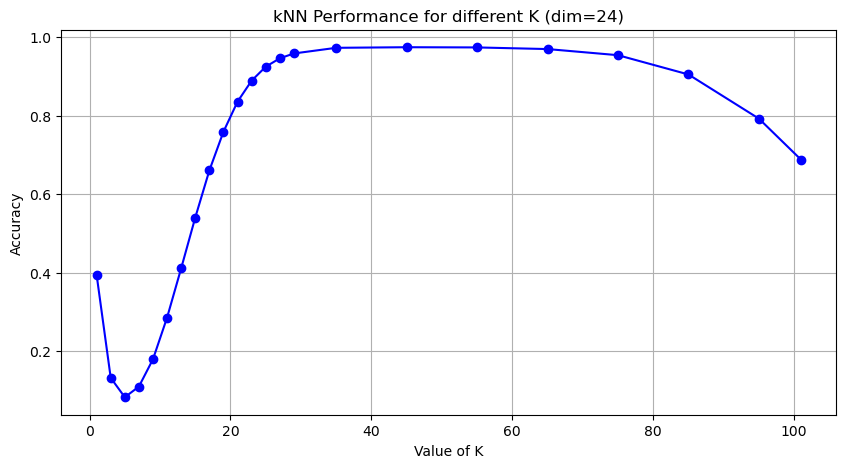

In [10]:
plot_optimal_k(24)

## kryptonite-30

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


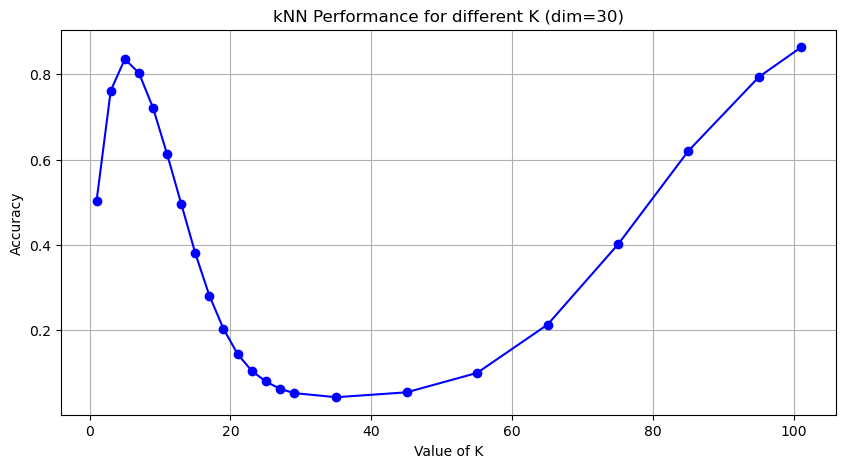

In [11]:
plot_optimal_k(30)

## kryptonite-45

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


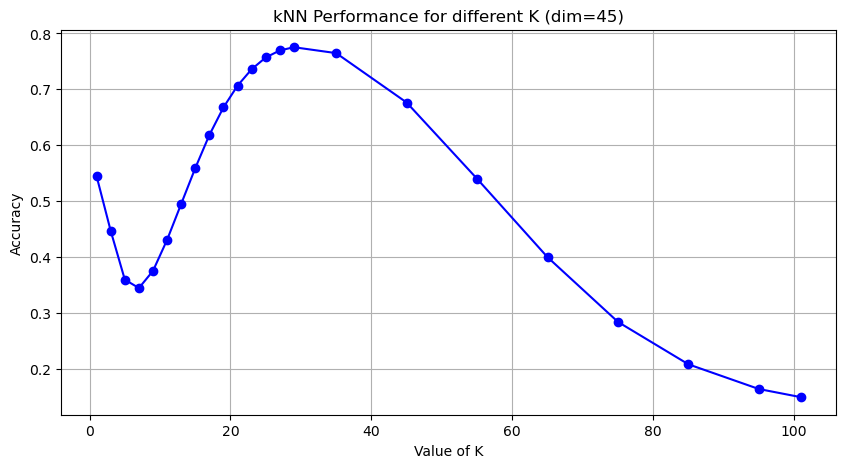

In [13]:
plot_optimal_k(45)

In [ ]:
best_ks=[9,5,5,3,35,45,35]
Knn_models=[]
dimensions=[9,12,15,18,24,30,45]
accuracies=[]
for dim , k in zip(dimensions,best_ks):
  data, labels = load_data_by_dimension(dim)
  data = preprocess_data(data, variance_threshold=0.253)
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  Knn_models.append(model)

  y_pred = model.predict(X_test)
  if dim in [30]:
    y_pred=1-y_pred
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)


Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


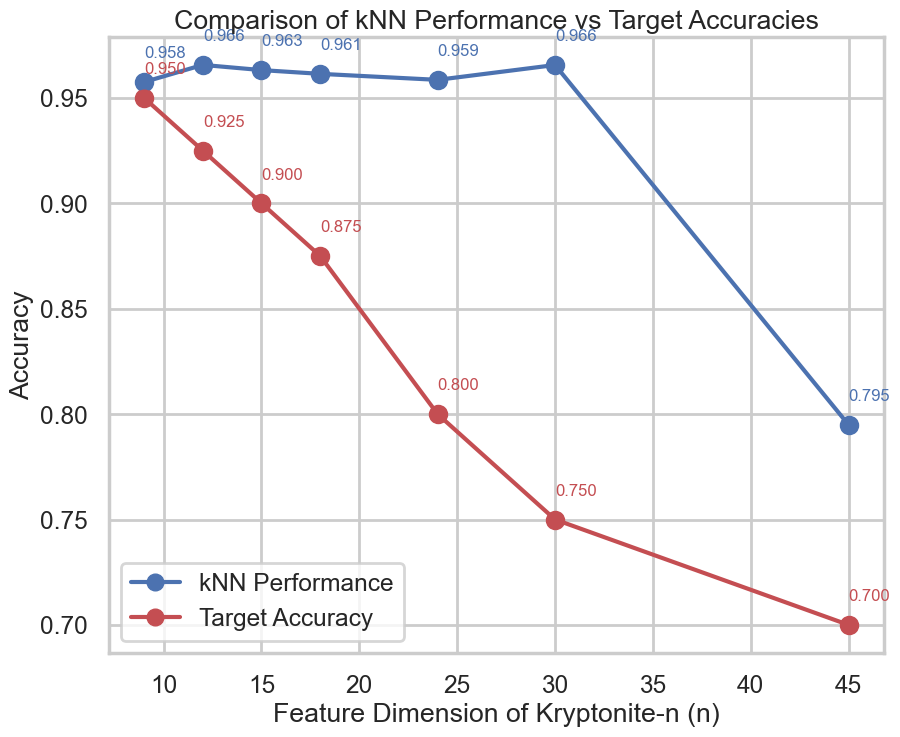

In [19]:
import seaborn as sns
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.plot(dimensions, accuracies, label='kNN Performance', marker='o', linestyle='-', color='b')
plt.scatter(dimensions, accuracies, color='b')

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
plt.scatter(n, target_accuracies, color='r')

# Annotating target accuracies
ax = plt.gca()
for j, (x, y) in enumerate(zip(n, target_accuracies)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='r', size=12)
for j, (x, y) in enumerate(zip(n, accuracies)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='b', size=12)

# Titles and labels
plt.title("Comparison of kNN Performance vs Target Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Feature Dimension of Kryptonite-n (n)")
plt.legend()

# Show the plot
plt.show()
